_Importing Required Libraries_

In [1]:
from importlib import reload
import pinn
reload(pinn)

<module 'pinn' from 'd:\\Prisha\\SEM 6\\Van-der-Pol-informed-Neural-Networks\\pinn.py'>

In [2]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\python311\lib\site-packages\pdfstructure-0.0.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array
import matplotlib.pyplot as plt

### generating vanderpol oscillator data (position and velocity) using range kutta method

In [5]:
from data_gen.vander_poll import rk4


In [7]:
def vanderpol(x, y, mu):
  return (y, mu*(1-x**2)*y - x)

mu = 4  # Parameter for nonlinearity
t_start = 0  # Starting time
t_end = 70  # End time
dt = 0.04  # Time step 
x0 = 1  # Initial position
y0 = 0  # Initial velocity

# Initialize lists for storing data
t = []
x = []
y = []

# Simulate using RK4
t.append(t_start)
x.append(x0)
y.append(y0)

for i in range(int((t_end - t_start) / dt)):
  next_point = rk4(vanderpol, x[-1], y[-1], dt, mu)
  t.append(t[-1] + dt)
  x.append(next_point[0])
  y.append(next_point[1])

print("Time:", t)
print("x:", x)
print("dx/dt:", y)

with open(r'.\Dataset\van_der_pol_intermittency.dat', "wb") as file:
    # Your code for writing to the file goes here
  for i in range(len(t)):
    velocity_bytes = str(y[i]).encode() + b' '  # Add space after converting to bytes
    position_bytes = str(x[i]).encode() + b'\n'  # Add newline after converting to bytes
    file.write(velocity_bytes)
    file.write(position_bytes)

Time: [0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24000000000000002, 0.28, 0.32, 0.36, 0.39999999999999997, 0.43999999999999995, 0.4799999999999999, 0.5199999999999999, 0.5599999999999999, 0.6, 0.64, 0.68, 0.7200000000000001, 0.7600000000000001, 0.8000000000000002, 0.8400000000000002, 0.8800000000000002, 0.9200000000000003, 0.9600000000000003, 1.0000000000000002, 1.0400000000000003, 1.0800000000000003, 1.1200000000000003, 1.1600000000000004, 1.2000000000000004, 1.2400000000000004, 1.2800000000000005, 1.3200000000000005, 1.3600000000000005, 1.4000000000000006, 1.4400000000000006, 1.4800000000000006, 1.5200000000000007, 1.5600000000000007, 1.6000000000000008, 1.6400000000000008, 1.6800000000000008, 1.7200000000000009, 1.760000000000001, 1.800000000000001, 1.840000000000001, 1.880000000000001, 1.920000000000001, 1.960000000000001, 2.000000000000001, 2.040000000000001, 2.080000000000001, 2.120000000000001, 2.160000000000001, 2.200000000000001, 2.240000000000001, 2.280000000000001, 2.320000000000001

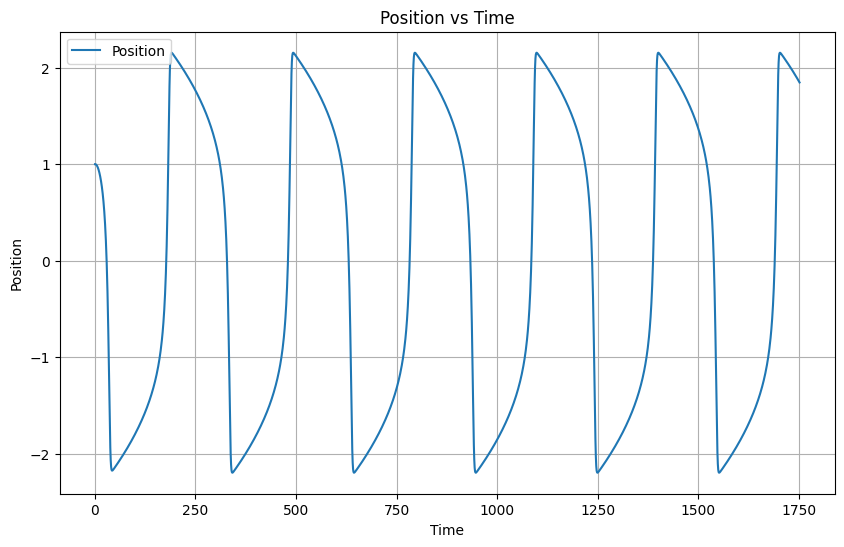

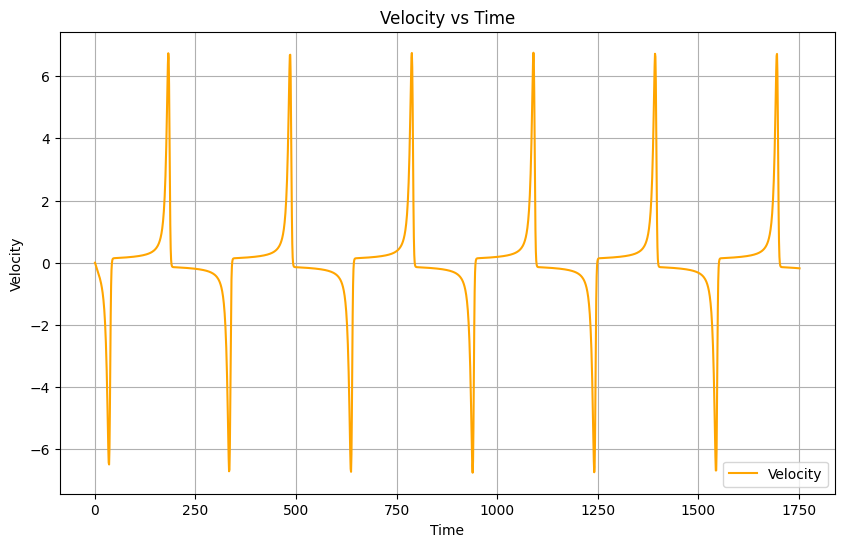

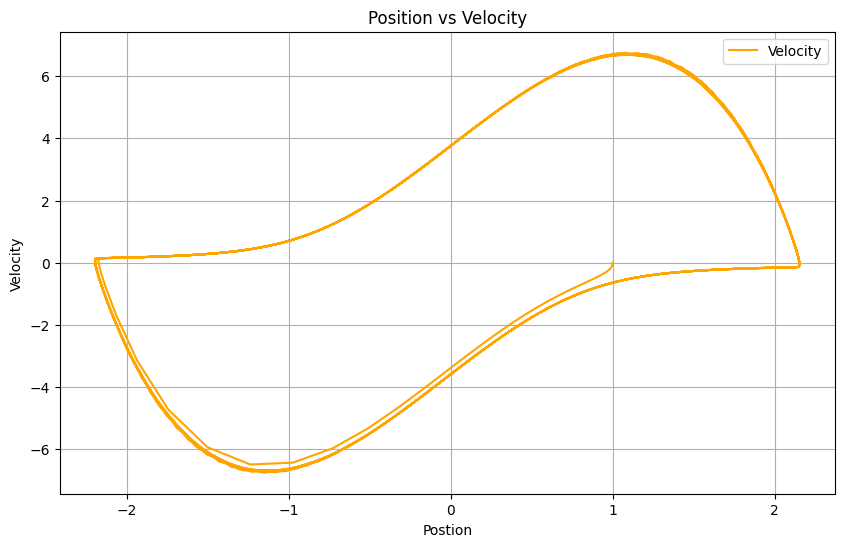

In [8]:
data = np.loadtxt(r'.\Dataset\van_der_pol_intermittency.dat')
# Extract columns from the data
time= np.arange(1,data.shape[0]+1)
velocity = data[:, 0]
position = data[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(time, position, label="Position")
plt.xlabel("Time")
plt.ylabel("Position")
plt.title("Position vs Time")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time, velocity, label="Velocity", color="orange")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.title("Velocity vs Time")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(position, velocity, label="Velocity", color="orange")
plt.xlabel("Postion")
plt.ylabel("Velocity")
plt.title("Position vs Velocity")
plt.legend()
plt.grid(True)
plt.show()


Data points written to ./Dataset/logistic_map_data.txt.


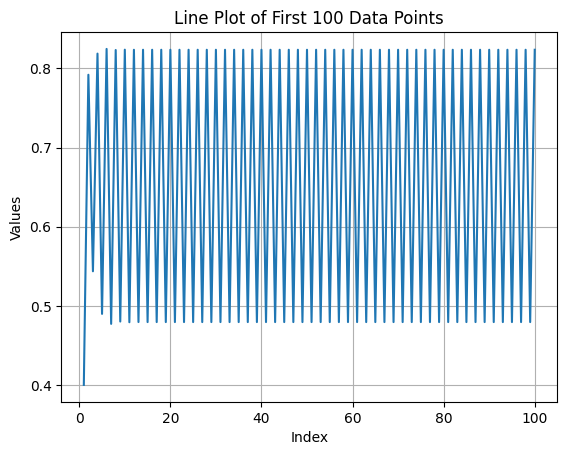

## Pretraining

The `van_der_pol_intermittency.dat` feeds the model with the dynamics of the Van der Pol Oscillator

In [13]:
data1 = np.genfromtxt(r'.\Dataset\van_der_pol_intermittency.dat')
training_set1 = pd.DataFrame(data1).reset_index(drop=True)
training_set1 = training_set1.iloc[:,1]

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [14]:
vpn = pinn.PINN(4,training_set1)
print("training set size",training_set1.shape)
print("gradient_t shape",vpn.gradient_t.shape)
print("gradient_tt shape",vpn.gradient_tt.shape)

training set size (1751,)
gradient_t shape (1750,)
gradient_tt shape (1749,)


## Loading Datasets

_दिल्ली WIND SPEED_

In [18]:
import pandas as pd
from pinn import PINN

# Load data from .dat file into a DataFrame
data = pd.read_csv("./Dataset/sis_data.dat", delimiter="\s+", header=None)

# Save the data to a CSV file
data.to_csv("./Dataset/sis_data.csv", index=False)

# Create an instance of the PINN class
vpn = PINN(mu=4, training=pd.DataFrame())

In [20]:
vpn.load_data("./Dataset/sis_data.csv", 0)
print(vpn.training_set.shape)

ValueError: cannot concatenate unaligned mixed dimensional NDFrame objects

In [72]:
vpn.convert(offset=30,in_val=35,out_val=10)
print("shape of trainX",vpn.trainX.shape)
print("shape of trainY",vpn.trainy.shape)
print("shape of forecastX",vpn.forecastX.shape)

shape of trainX (1407, 1, 37)
shape of trainY (1407, 30)
shape of forecastX (1, 1, 37)


In [73]:
vpn.train_model(type="VPINN")

VPINN


Epoch 1/100
18/18 [==============================] - 7s 98ms/step - loss: 64.0952 - val_loss: 56.1876
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 46.0807 - val_loss: 40.3194
Epoch 3/100
18/18 [==============================] - 0s 12ms/step - loss: 36.9343 - val_loss: 33.6831
Epoch 4/100
18/18 [==============================] - 0s 13ms/step - loss: 32.5662 - val_loss: 29.8483
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 29.9502 - val_loss: 27.1267
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 27.8756 - val_loss: 24.9260
Epoch 7/100
18/18 [==============================] - 0s 14ms/step - loss: 26.2985 - val_loss: 23.1574
Epoch 8/100
18/18 [==============================] - 0s 10ms/step - loss: 25.0435 - val_loss: 21.7693
Epoch 9/100
18/18 [==============================] - 0s 11ms/step - loss: 24.1429 - val_loss: 20.6357
Epoch 10/100
18/18 [==============================] - 0s 10ms/step - loss: 23.4208

In [75]:
vpn.evaluate_model()

1/1 [==============================] - 1s 556ms/step


8.500364652795577

In [76]:
final_forecast = vpn.final_forecast
print(final_forecast)
print(final_forecast.shape)


[[3.4566154  0.62962043 0.60606563 0.         0.         0.5985383
  0.09143464 0.         0.         0.        ]]
(1, 10)


In [77]:
true_forecast = vpn.true_forecast
print(true_forecast)
print(true_forecast.shape)

[[ 3.43        8.02777778  9.87916667  3.91666667  6.73157895  6.42083333
  10.41428571 15.92666667 19.4047619   6.18095238]]
(1, 10)


In [80]:
error = vpn.evaluate_model()
print(error)

1/1 [==============================] - 0s 29ms/step
8.500364652795577


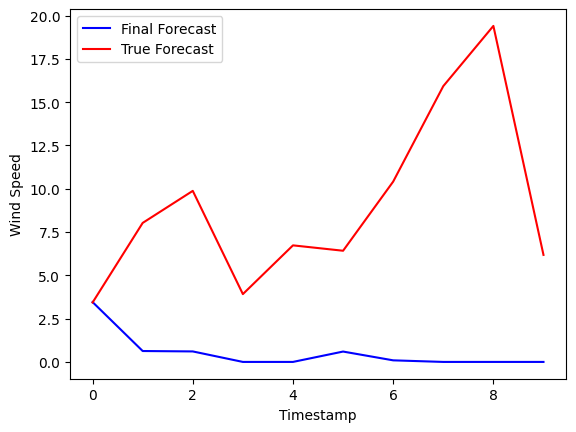

In [81]:
vpn.plot_forecasts(final_forecast=final_forecast,true_forecast=true_forecast)